In [2]:
from data_selector import data_selector
import georinex as gr
import matplotlib.pyplot as plt
import numpy as np
from sv_functions import calculate_multipath_error, get_azimuth_elevation
import os
from scipy.optimize import curve_fit
import scipy.signal
import re

def fit_sin(tt, yy, max_evals=5000):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = curve_fit(sinfunc, tt, yy, p0=guess, maxfev=max_evals)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

def get_date(path):
    expression = r'\d{6}'

    return re.search(expression,path)[0]

def normalize_amplitude_timeseries(data):
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)

    normalized_data = (data - np.nanmean(data))/(max_val - min_val)

    return normalized_data

def normalize_amplitude_timeseries_half(data):
    
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)
    normalized_data = [(-0.5) + ((x - min_val) * (0.5 - (-0.5)) / (max_val - min_val)) for x in data]
    
    return np.array(normalized_data)

def normalize_amplitude_timeseries_whole(dataset):
    min_val = np.nanmin(dataset)
    max_val = np.nanmax(dataset)
    normalized_dataset = [(x - min_val) / (max_val - min_val) * 2 - 1 for x in dataset]
    return np.array(normalized_dataset)

def moving_average(arr, window_size=50):
    padded_arr = np.pad(arr, (window_size // 2, window_size // 2), mode='edge')
    cumsum = np.cumsum(padded_arr)
    moving_avg = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
    return moving_avg

def stft(signal, window_size, hop_length):
    """
    source: https://medium.com/@ongzhixuan/exploring-the-short-time-fourier-transform-analyzing-time-varying-audio-signals-98157d1b9a12
    """
    n_frames = 1 + (len(signal) - window_size) // hop_length
    stft_matrix = np.empty((window_size // 2 + 1, n_frames), dtype=complex)

    for i in range(n_frames):
        frame = signal[i * hop_length: i * hop_length + window_size]
        windowed_frame = frame * np.hamming(window_size)
        stft_matrix[:, i] = np.fft.rfft(windowed_frame)

    return stft_matrix

def interpolate_nans(array):
    nan_idx = np.isnan(array)
    non_nan_idx = ~nan_idx
    idx = np.arange(len(array))

    array_interp = np.interp(idx, idx[non_nan_idx], array[non_nan_idx])

    return array_interp


In [3]:
files = data_selector()

if len(files) == 6:
    obs_short, nav_short, obs_medium, nav_medium, obs_long, nav_long = files

    if 'glass' in obs_short:
        wall_type = 'glass'
        perp_from_wall = 195 # deg
    elif 'metal' in obs_short:
        wall_type = 'metal'
        perp_from_wall = 286 # deg
    elif 'brick' in obs_short:
        wall_type = 'brick'
        perp_from_wall = 106 # deg
    else:
        wall_type = ''
        perp_from_wall = 0

    date = get_date(obs_short)

    if 'galileo' in nav_short:
        obs_short = gr.load(obs_short,use="E")
        obs_medium = gr.load(obs_medium,use="E")
        obs_long = gr.load(obs_long,use="E")
        nav_short = gr.load(nav_short)
        nav_medium = gr.load(nav_medium)
        nav_long = gr.load(nav_long)
        system = 'galileo'
    else:
        obs_short = gr.load(obs_short,use="G")
        obs_medium = gr.load(obs_medium,use="G")
        obs_long = gr.load(obs_long,use="G")
        nav_short = gr.load(nav_short)
        nav_medium = gr.load(nav_medium)
        nav_long = gr.load(nav_long)
        system = 'gps'
elif len(files) == 4:
    obs_main, nav_main, obs_aux, nav_aux = files

    if 'glass' in obs_main:
        wall_type = 'glass'
        perp_from_wall = 195 # deg
    elif 'metal' in obs_main:
        wall_type = 'metal'
        perp_from_wall = 286 # deg
    elif 'brick' in obs_main:
        wall_type = 'brick'
        perp_from_wall = 106 # deg
    else:
        wall_type = ''
        perp_from_wall = 0

    date = get_date(obs_main)

    if 'galileo' in nav_main:
        obs_main = gr.load(obs_main,use="E")
        obs_aux = gr.load(obs_aux,use="E")
        nav_main = gr.load(nav_main)
        nav_aux = gr.load(nav_aux)
        system = 'galileo'
    else:
        obs_main = gr.load(obs_main,use="G")
        obs_aux = gr.load(obs_aux,use="G")
        nav_main = gr.load(nav_main)
        nav_aux = gr.load(nav_aux)
        system = 'gps'


if not wall_type == '':
    title_string = f'10 m to {wall_type} wall'
else:
    title_string = f'clear sky conditions'

You selected: brick
You selected: distance_correlations
Only one date available. 210424 has been picked.
You picked GPS.
There was found 3 different serial numbers in the folder. This is a distance correlation folder.


In [4]:
## Configure sv list and constants

if system == 'gps':
    if wall_type == 'glass':
        interesting_svs_gps = ['G26','G27'] # glass
    elif wall_type == 'brick':
        interesting_svs_gps = ['G11'] # ['G11', 'G25'] # brick 
    elif wall_type == 'metal':
        interesting_svs_gps = ['G28'] # metal 
    else:
        interesting_svs_gps = []
    if len(files) == 6:
        sv_list_gps_short = obs_short.sv.values
        sv_list_gps_medium = obs_medium.sv.values
        sv_list_gps_long = obs_long.sv.values
        sv_list_gps = [sv for sv in sv_list_gps_long if sv in sv_list_gps_medium and sv in sv_list_gps_short]
        print(sv_list_gps)
    elif len(files) == 4:
        sv_list_gps_main = obs_main.sv.values
        sv_list_gps_aux = obs_aux.sv.values
        sv_list_gps = [sv for sv in sv_list_gps_main if sv in sv_list_gps_aux]
        print(sv_list_gps)
else:
    interesting_svs_gal = ['E02','E25','E36','E11','E10']
    if len(files) == 6:
        sv_list_gal_short = obs_short.sv.values
        sv_list_gal_medium = obs_medium.sv.values
        sv_list_gal_long = obs_long.sv.values
        sv_list_gal = [sv for sv in sv_list_gal_long if sv in sv_list_gal_medium and sv in sv_list_gal_short]
        print(sv_list_gal)
    elif len(files) == 4:
        sv_list_gal_main = obs_main.sv.values
        sv_list_gal_aux = obs_aux.sv.values
        sv_list_gal = [sv for sv in sv_list_gal_main if sv in sv_list_gal_aux]
        print(sv_list_gal)

if system == 'gps':
    sv_list = sv_list_gps
    interesting_svs = interesting_svs_gps
else:
    sv_list = sv_list_gal
    interesting_svs = interesting_svs_gal

c = 299792458

freq_E1 = 1575.42e6
freq_E5a = 1176.45e6
freq_E5b = 1207.14e6
freq_E5ab = 1191.795e6
freq_E6 = 1278.75e6

freq_L1 = 1575.42e6
freq_L2 = 1227.60e6
freq_L5 = 1176.45e6

CN0_L1_selector = 'S1C'
CN0_L2_selector = 'S2L'
CN0_L5_selector = 'S5Q'
CN0_E1_selector = "S1C"
CN0_E5a_selector = "S5Q"
CN0_E5b_selector = "S7Q"
CN0_E5ab_selector = "S8Q"

pseudorange_L1_selector = 'C1C'
pseudorange_L2_selector = 'C2L'
pseudorange_L5_selector = 'C5Q'
pseudorange_E1_selector = "C1C"
pseudorange_E5a_selector = "C5Q"
pseudorange_E5b_selector = "C7Q"
pseudorange_E5ab_selector = "C8Q"

carrier_phase_L1_selector = 'L1C'
carrier_phase_L2_selector = 'L2L'
carrier_phase_L5_selector = 'L5Q'
carrier_phase_E1_selector = "L1C"
carrier_phase_E5a_selector = "L5Q"
carrier_phase_E5b_selector = "L7Q"
carrier_phase_E5ab_selector = "L8Q"

['G06', 'G11', 'G12', 'G20', 'G25', 'G29']


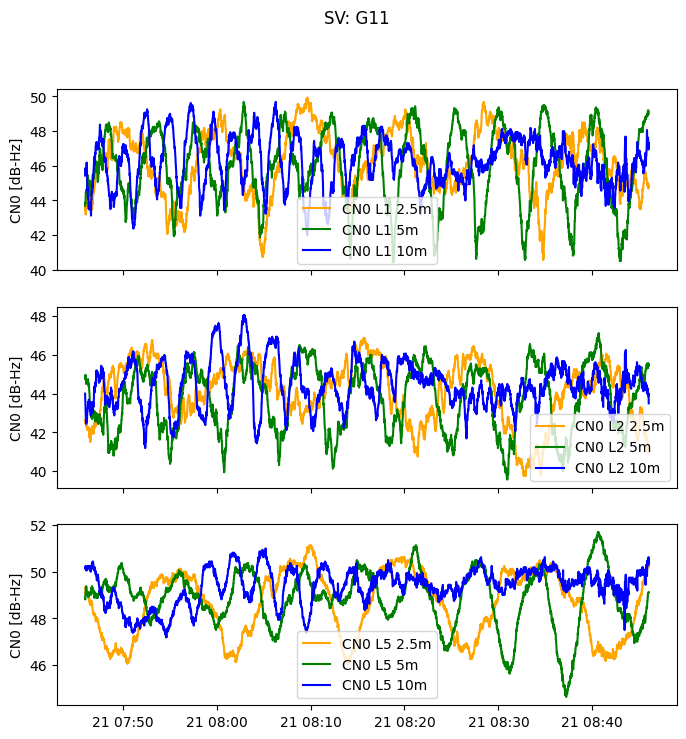

In [4]:
## Pure CN0 block

for sv in sv_list:
    if sv not in interesting_svs:
        continue

    if not np.sum(np.isnan(obs_short.sel(sv=sv)[CN0_L5_selector].values)) == len(obs_short.sel(sv=sv)[CN0_L5_selector].values):
        
        fig,ax = plt.subplots(3,1,figsize=(8,8),sharex=True)
        fig.suptitle(f'SV: {sv}')
        ax[0].plot(obs_short.time.values, obs_short.sel(sv=sv)[CN0_L1_selector], color='orange', label='CN0 L1 2.5m')
        ax[0].plot(obs_medium.time.values, obs_medium.sel(sv=sv)[CN0_L1_selector], color='green', label='CN0 L1 5m')
        ax[0].plot(obs_long.time.values, obs_long.sel(sv=sv)[CN0_L1_selector], color='blue', label='CN0 L1 10m')
        ax[0].legend()
        ax[0].set_ylabel('CN0 [dB-Hz]')

        ax[1].plot(obs_short.time.values, obs_short.sel(sv=sv)[CN0_L2_selector], color='orange', label='CN0 L2 2.5m')
        ax[1].plot(obs_medium.time.values, obs_medium.sel(sv=sv)[CN0_L2_selector], color='green', label='CN0 L2 5m')
        ax[1].plot(obs_long.time.values, obs_long.sel(sv=sv)[CN0_L2_selector], color='blue', label='CN0 L2 10m')
        ax[1].legend()
        ax[1].set_ylabel('CN0 [dB-Hz]')

        ax[2].plot(obs_short.time.values, obs_short.sel(sv=sv)[CN0_L5_selector], color='orange', label='CN0 L5 2.5m')
        ax[2].plot(obs_medium.time.values, obs_medium.sel(sv=sv)[CN0_L5_selector], color='green', label='CN0 L5 5m')
        ax[2].plot(obs_long.time.values, obs_long.sel(sv=sv)[CN0_L5_selector], color='blue', label='CN0 L5 10m')
        ax[2].legend()
        ax[2].set_ylabel('CN0 [dB-Hz]')

        plt.savefig(f'..{os.sep}figs{os.sep}distance_correlation{os.sep}cn0{os.sep}raw_cn0_{sv}_{wall_type}_{date}.png')
        plt.savefig(f'..{os.sep}figs{os.sep}distance_correlation{os.sep}cn0{os.sep}raw_cn0_{sv}_{wall_type}_{date}.pdf')
        plt.show()
        
        


L1 short distance period: 585.84 s
L1 medium distance period: 281.97 s
L1 long distance period: 138.30 s

L2 short distance period: 724.55 s
L2 medium distance period: 363.38 s
L2 long distance period: 179.61 s

L5 short distance period: 773.30 s
L5 medium distance period: 378.95 s
L5 long distance period: 184.88 s


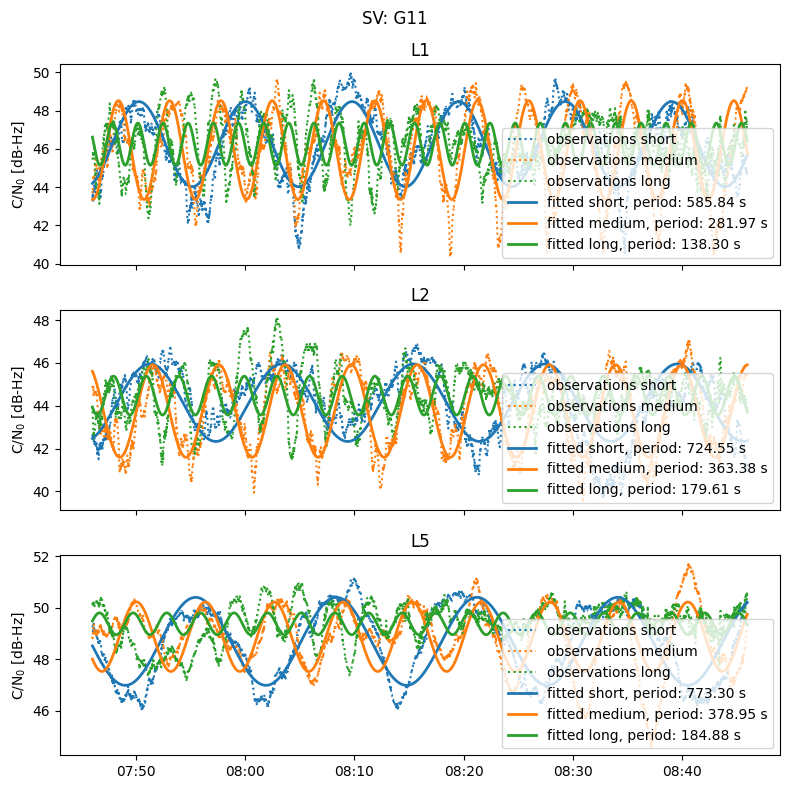

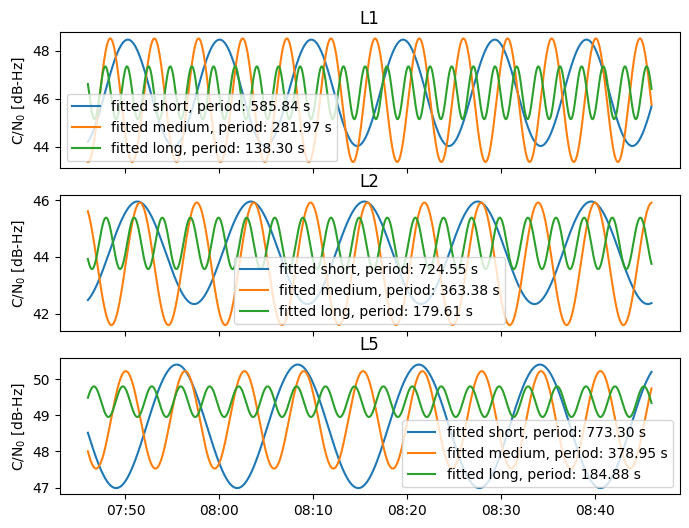

In [11]:
## Analyzing CN0 with sinus curve fitting

# only looking at short distance to wall with gps

L1_color = '#1f77b4'
L2_color = '#ff7f0e'
L5_color = '#2ca02c'

# threshold are found empirical by inspecting the data and finding relevant threshold that will remove overlying sinus curves
# that are not interesting to look at, since there may be other reflectors.
threshold_short = 1e-3
threshold_medium = 1e-3
threshold_long = 5e-3
get_within_threshold = True

for sv in sv_list:

    if sv not in interesting_svs:
        continue

    cn0_L1_short = obs_short.sel(sv=sv)[CN0_L1_selector]
    cn0_L2_short = obs_short.sel(sv=sv)[CN0_L2_selector]
    cn0_L5_short = obs_short.sel(sv=sv)[CN0_L5_selector]
    t_L1_short = np.linspace(0,len(cn0_L1_short)-1,len(cn0_L1_short))
    t_L2_short = np.linspace(0,len(cn0_L2_short)-1,len(cn0_L2_short))
    t_L5_short = np.linspace(0,len(cn0_L5_short)-1,len(cn0_L5_short))

    sinus_L1_short = fit_sin(t_L1_short, cn0_L1_short)
    sinus_L2_short = fit_sin(t_L2_short, cn0_L2_short)
    sinus_L5_short = fit_sin(t_L5_short, cn0_L5_short)

    if get_within_threshold:
        cn0_L1_short_new = cn0_L1_short
        while sinus_L1_short["freq"] < threshold_short:
            cn0_L1_short_new = cn0_L1_short_new - sinus_L1_short["fitfunc"](t_L1_short) + np.mean(cn0_L1_short)
            sinus_L1_short = fit_sin(t_L1_short, cn0_L1_short_new)
        cn0_L2_short_new = cn0_L2_short
        while sinus_L2_short["freq"] < threshold_short:
            cn0_L2_short_new = cn0_L2_short_new - sinus_L2_short["fitfunc"](t_L2_short) + np.mean(cn0_L2_short)
            sinus_L2_short = fit_sin(t_L2_short, cn0_L2_short_new)
        cn0_L5_short_new = cn0_L5_short
        while sinus_L5_short["freq"] < threshold_short:
            cn0_L5_short_new = cn0_L5_short_new - sinus_L5_short["fitfunc"](t_L5_short) + np.mean(cn0_L5_short)
            sinus_L5_short = fit_sin(t_L5_short, cn0_L5_short_new)

    cn0_L1_medium = obs_medium.sel(sv=sv)[CN0_L1_selector]
    cn0_L2_medium = obs_medium.sel(sv=sv)[CN0_L2_selector]
    cn0_L5_medium = obs_medium.sel(sv=sv)[CN0_L5_selector]
    t_L1_medium = np.linspace(0,len(cn0_L1_medium)-1,len(cn0_L1_medium))
    t_L2_medium = np.linspace(0,len(cn0_L2_medium)-1,len(cn0_L2_medium))
    t_L5_medium = np.linspace(0,len(cn0_L5_medium)-1,len(cn0_L5_medium))

    sinus_L1_medium = fit_sin(t_L1_medium, cn0_L1_medium)
    sinus_L2_medium = fit_sin(t_L2_medium, cn0_L2_medium)
    sinus_L5_medium = fit_sin(t_L5_medium, cn0_L5_medium)

    if get_within_threshold:
        cn0_L1_medium_new = cn0_L1_medium
        while sinus_L1_medium["freq"] < threshold_medium:
            cn0_L1_medium_new = cn0_L1_medium_new - sinus_L1_medium["fitfunc"](t_L1_medium) + np.mean(cn0_L1_medium)
            sinus_L1_medium = fit_sin(t_L1_medium, cn0_L1_medium_new)
        cn0_L2_medium_new = cn0_L2_medium
        while sinus_L2_medium["freq"] < threshold_medium:
            cn0_L2_medium_new = cn0_L2_medium_new - sinus_L2_medium["fitfunc"](t_L2_medium) + np.mean(cn0_L2_medium)
            sinus_L2_medium = fit_sin(t_L2_medium, cn0_L2_medium_new)
        cn0_L5_medium_new = cn0_L5_medium
        while sinus_L5_medium["freq"] < threshold_medium:
            cn0_L5_medium_new = cn0_L5_medium_new - sinus_L5_medium["fitfunc"](t_L5_medium) + np.mean(cn0_L5_medium)
            sinus_L5_medium = fit_sin(t_L5_medium, cn0_L5_medium_new)

    cn0_L1_long = obs_long.sel(sv=sv)[CN0_L1_selector]
    cn0_L2_long = obs_long.sel(sv=sv)[CN0_L2_selector]
    cn0_L5_long = obs_long.sel(sv=sv)[CN0_L5_selector]
    t_L1_long = np.linspace(0,len(cn0_L1_long)-1,len(cn0_L1_long))
    t_L2_long = np.linspace(0,len(cn0_L2_long)-1,len(cn0_L2_long))
    t_L5_long = np.linspace(0,len(cn0_L5_long)-1,len(cn0_L5_long))
    
    sinus_L1_long = fit_sin(t_L1_long, cn0_L1_long)
    sinus_L2_long = fit_sin(t_L2_long, cn0_L2_long)
    sinus_L5_long = fit_sin(t_L5_long, cn0_L5_long)

    if get_within_threshold:
        cn0_L1_long_new = cn0_L1_long
        while sinus_L1_long["freq"] < threshold_long:
            cn0_L1_long_new = cn0_L1_long_new - sinus_L1_long["fitfunc"](t_L1_long) + np.mean(cn0_L1_long)
            sinus_L1_long = fit_sin(t_L1_long, cn0_L1_long_new)
        cn0_L2_long_new = cn0_L2_long
        while sinus_L2_long["freq"] < threshold_long:
            cn0_L2_long_new = cn0_L2_long_new - sinus_L2_long["fitfunc"](t_L2_long) + np.mean(cn0_L2_long)
            sinus_L2_long = fit_sin(t_L2_long, cn0_L2_long_new)
        cn0_L5_long_new = cn0_L5_long
        while sinus_L5_long["freq"] < threshold_long:
            cn0_L5_long_new = cn0_L5_long_new - sinus_L5_long["fitfunc"](t_L5_long) + np.mean(cn0_L5_long)
            sinus_L5_long = fit_sin(t_L5_long, cn0_L5_long_new)

    print(f'L1 short distance period: {sinus_L1_short["period"]:.2f} s')
    print(f'L1 medium distance period: {sinus_L1_medium["period"]:.2f} s')
    print(f'L1 long distance period: {sinus_L1_long["period"]:.2f} s')
    print('')
    print(f'L2 short distance period: {sinus_L2_short["period"]:.2f} s')
    print(f'L2 medium distance period: {sinus_L2_medium["period"]:.2f} s')
    print(f'L2 long distance period: {sinus_L2_long["period"]:.2f} s')
    print('')
    print(f'L5 short distance period: {sinus_L5_short["period"]:.2f} s')
    print(f'L5 medium distance period: {sinus_L5_medium["period"]:.2f} s')
    print(f'L5 long distance period: {sinus_L5_long["period"]:.2f} s')

    fig,ax = plt.subplots(3,1,figsize=(8,8),sharex=True)
    plt.suptitle(f'SV: {sv}')
    ax[0].plot(obs_short.time.values,cn0_L1_short,color=L1_color,linestyle=':',label=f'observations short')
    ax[0].plot(obs_medium.time.values,cn0_L1_medium,color=L2_color,linestyle=':',label=f'observations medium')
    ax[0].plot(obs_long.time.values,cn0_L1_long,color=L5_color,linestyle=':',label=f'observations long')
    ax[0].plot(obs_short.time.values,sinus_L1_short["fitfunc"](t_L1_short),linewidth=2,linestyle='-',color=L1_color,label=f'fitted short, period: {sinus_L1_short["period"]:.2f} s')
    ax[0].plot(obs_medium.time.values,sinus_L1_medium["fitfunc"](t_L1_medium),linewidth=2,linestyle='-',color=L2_color,label=f'fitted medium, period: {sinus_L1_medium["period"]:.2f} s')
    ax[0].plot(obs_long.time.values,sinus_L1_long["fitfunc"](t_L1_long),linewidth=2,linestyle='-',color=L5_color,label=f'fitted long, period: {sinus_L1_long["period"]:.2f} s')
    ax[0].set_ylabel(f'C/N$_0$ [dB-Hz]')
    ax[0].set_title('L1')
    ax[0].legend(loc='lower right')

    ax[1].plot(obs_short.time.values,cn0_L2_short,color=L1_color,linestyle=':',label=f'observations short')
    ax[1].plot(obs_medium.time.values,cn0_L2_medium,color=L2_color,linestyle=':',label=f'observations medium')
    ax[1].plot(obs_long.time.values,cn0_L2_long,color=L5_color,linestyle=':',label=f'observations long')
    ax[1].plot(obs_short.time.values,sinus_L2_short["fitfunc"](t_L2_short),linewidth=2,linestyle='-',color=L1_color,label=f'fitted short, period: {sinus_L2_short["period"]:.2f} s')
    ax[1].plot(obs_medium.time.values,sinus_L2_medium["fitfunc"](t_L2_medium),linewidth=2,linestyle='-',color=L2_color,label=f'fitted medium, period: {sinus_L2_medium["period"]:.2f} s')
    ax[1].plot(obs_long.time.values,sinus_L2_long["fitfunc"](t_L2_long),linewidth=2,linestyle='-',color=L5_color,label=f'fitted long, period: {sinus_L2_long["period"]:.2f} s')
    ax[1].set_ylabel(f'C/N$_0$ [dB-Hz]')
    ax[1].set_title('L2')
    ax[1].legend(loc='lower right')

    ax[2].plot(obs_short.time.values,cn0_L5_short,color=L1_color,linestyle=':',label=f'observations short')
    ax[2].plot(obs_medium.time.values,cn0_L5_medium,color=L2_color,linestyle=':',label=f'observations medium')
    ax[2].plot(obs_long.time.values,cn0_L5_long,color=L5_color,linestyle=':',label=f'observations long')
    ax[2].plot(obs_short.time.values,sinus_L5_short["fitfunc"](t_L5_short),linewidth=2,linestyle='-',color=L1_color,label=f'fitted short, period: {sinus_L5_short["period"]:.2f} s')
    ax[2].plot(obs_medium.time.values,sinus_L5_medium["fitfunc"](t_L5_medium),linewidth=2,linestyle='-',color=L2_color,label=f'fitted medium, period: {sinus_L5_medium["period"]:.2f} s')
    ax[2].plot(obs_long.time.values,sinus_L5_long["fitfunc"](t_L5_long),linewidth=2,linestyle='-',color=L5_color,label=f'fitted long, period: {sinus_L5_long["period"]:.2f} s')
    ax[2].set_ylabel(f'C/N$_0$ [dB-Hz]')
    ax[2].set_title('L5')
    ax[2].legend(loc='lower right')

    ax[2].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))

    plt.tight_layout()
    plt.savefig(f'..{os.sep}figs{os.sep}distance_correlation{os.sep}cn0{os.sep}sinus_curves_cn0_{sv}_{wall_type}_{date}.png')
    plt.savefig(f'..{os.sep}figs{os.sep}distance_correlation{os.sep}cn0{os.sep}sinus_curves_cn0_{sv}_{wall_type}_{date}.pdf')
    plt.show()

    fig,ax = plt.subplots(3,1,figsize=(8,6),sharex=True)
    ax[0].set_title('L1')
    ax[0].plot(obs_short.time.values,sinus_L1_short["fitfunc"](t_L1_short),color=L1_color,label=f'fitted short, period: {sinus_L1_short["period"]:.2f} s')
    ax[0].plot(obs_medium.time.values,sinus_L1_medium["fitfunc"](t_L1_medium),color=L2_color,label=f'fitted medium, period: {sinus_L1_medium["period"]:.2f} s')
    ax[0].plot(obs_long.time.values,sinus_L1_long["fitfunc"](t_L1_long),color=L5_color,label=f'fitted long, period: {sinus_L1_long["period"]:.2f} s')
    ax[0].set_ylabel(f'C/N$_0$ [dB-Hz]')
    ax[0].legend()

    ax[1].set_title('L2')
    ax[1].plot(obs_short.time.values,sinus_L2_short["fitfunc"](t_L2_short),color=L1_color,label=f'fitted short, period: {sinus_L2_short["period"]:.2f} s')
    ax[1].plot(obs_medium.time.values,sinus_L2_medium["fitfunc"](t_L2_medium),color=L2_color,label=f'fitted medium, period: {sinus_L2_medium["period"]:.2f} s')
    ax[1].plot(obs_long.time.values,sinus_L2_long["fitfunc"](t_L2_long),color=L5_color,label=f'fitted long, period: {sinus_L2_long["period"]:.2f} s')
    ax[1].set_ylabel(f'C/N$_0$ [dB-Hz]')
    ax[1].legend()

    ax[2].set_title('L5')
    ax[2].plot(obs_short.time.values,sinus_L5_short["fitfunc"](t_L5_short),color=L1_color,label=f'fitted short, period: {sinus_L5_short["period"]:.2f} s')
    ax[2].plot(obs_medium.time.values,sinus_L5_medium["fitfunc"](t_L5_medium),color=L2_color,label=f'fitted medium, period: {sinus_L5_medium["period"]:.2f} s')
    ax[2].plot(obs_long.time.values,sinus_L5_long["fitfunc"](t_L5_long),color=L5_color,label=f'fitted long, period: {sinus_L5_long["period"]:.2f} s')
    ax[2].set_ylabel(f'C/N$_0$ [dB-Hz]')
    ax[2].legend()

    ax[2].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
    plt.show()



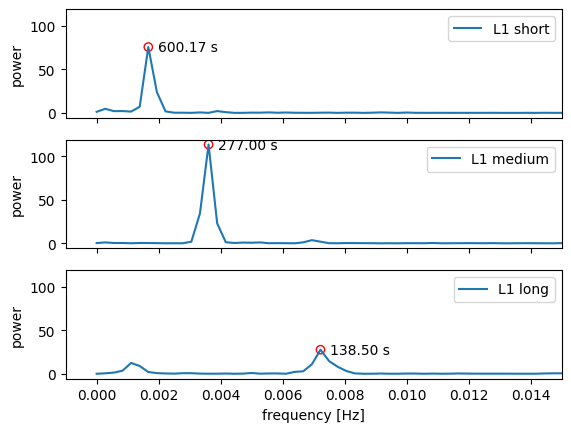

/tmp/ipykernel_450824/2304460490.py:280: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


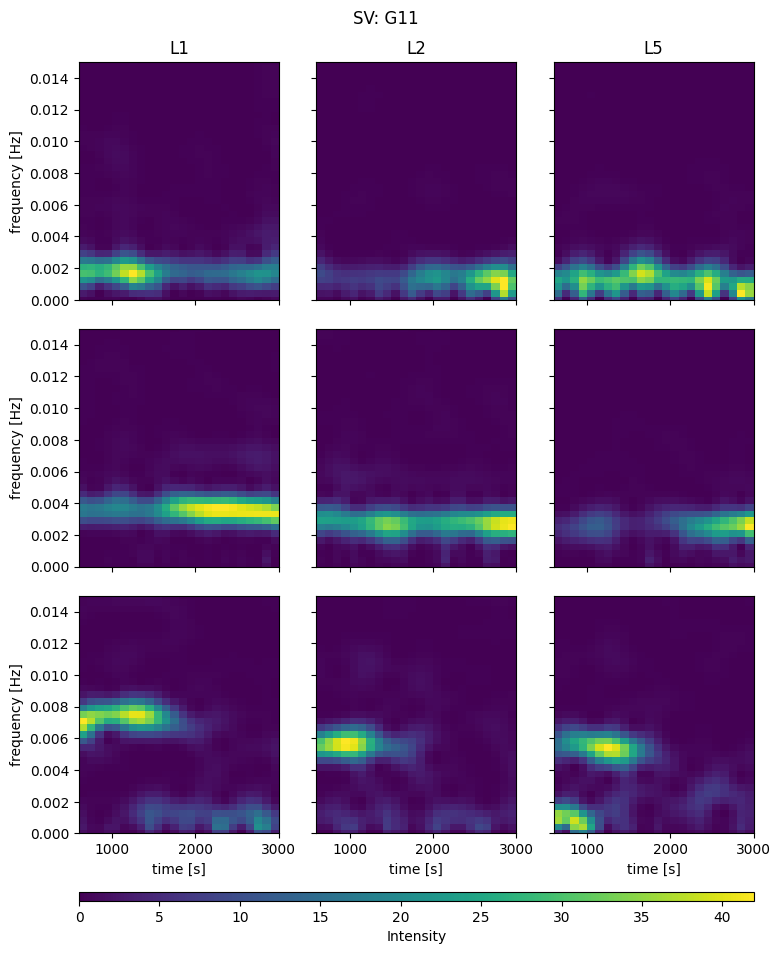

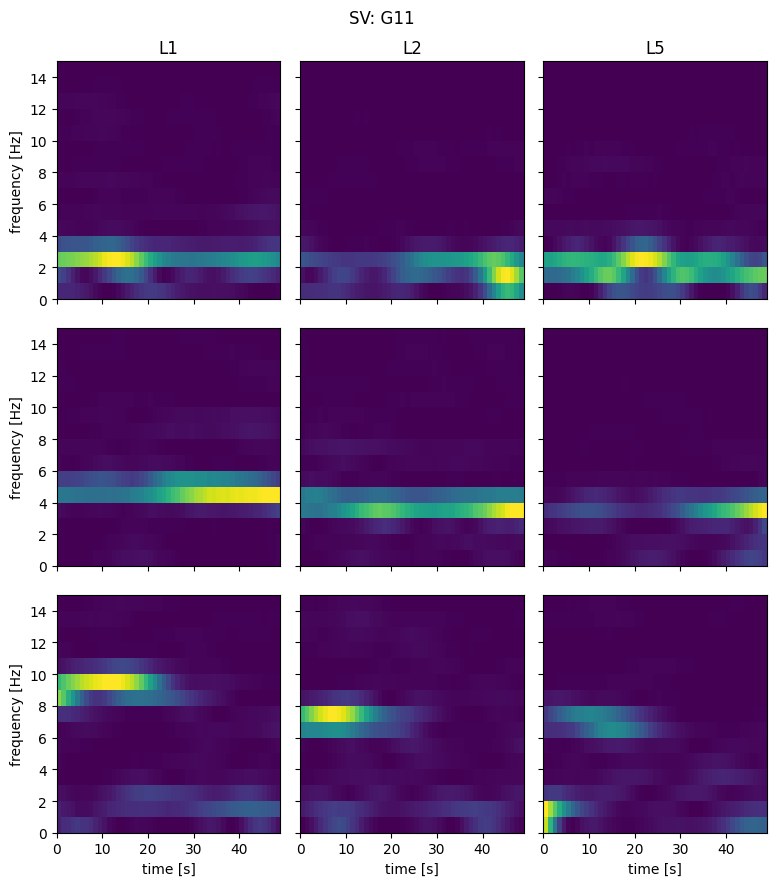

In [56]:
CALCULATE_EXTRA_PATH = False
PLOT_ORIGINAL_DATA = False
PLOT_SCALED_DATA = False

PERFORM_MOVING_AVERAGE = True

PERFORM_WHOLE_AMPLITUDE_NORMALIZATION = False
PERFORM_HALF_AMPLITUDE_NORMALIZATION = False
PERFORM_GENERAL_AMPLITUDE_NORMALIZATION = True

WINDOW_SIZE = 14

if not WINDOW_SIZE % 2 == 0:
    WINDOW_SIZE += 1

for _, sv in enumerate(sv_list_gps):
    if sv not in interesting_svs_gps:
        continue

    cn0_L1_short = obs_short.sel(sv=sv)[CN0_L1_selector].values.copy()
    cn0_L1_medium = obs_medium.sel(sv=sv)[CN0_L1_selector].values.copy()
    cn0_L1_long = obs_long.sel(sv=sv)[CN0_L1_selector].values.copy()

    cn0_L2_short = obs_short.sel(sv=sv)[CN0_L2_selector].values.copy()
    cn0_L2_medium = obs_medium.sel(sv=sv)[CN0_L2_selector].values.copy()
    cn0_L2_long = obs_long.sel(sv=sv)[CN0_L2_selector].values.copy()

    cn0_L5_short = obs_short.sel(sv=sv)[CN0_L5_selector].values.copy()
    cn0_L5_medium = obs_medium.sel(sv=sv)[CN0_L5_selector].values.copy()
    cn0_L5_long = obs_long.sel(sv=sv)[CN0_L5_selector].values.copy()

    if PLOT_ORIGINAL_DATA:

        t = np.linspace(1, len(cn0_L1_long), len(cn0_L1_long))

        sinus_L1_short = fit_sin(t, cn0_L1_short)
        sinus_L1_medium = fit_sin(t, cn0_L1_medium)
        sinus_L1_long = fit_sin(t, cn0_L1_long)

        fig, ax = plt.subplots(3,figsize=(8,9),sharex=True,sharey=True)
        plt.suptitle(f'SV: {sv}')
        ax[0].plot(t, cn0_L1_short, label=f'CN0 obs')
        ax[0].plot(t, sinus_L1_short["fitfunc"](t), label=f'period: {sinus_L1_short["period"]:.1f} s')
        ax[0].legend()
        ax[0].set_ylabel(f'$C/N_0$ [dB-Hz]')
        ax[0].set_title('short distance')
        ax[1].plot(t, cn0_L1_medium, label=f'CN0 obs')
        ax[1].plot(t, sinus_L1_medium["fitfunc"](t), label=f'period: {sinus_L1_medium["period"]:.1f} s')
        ax[1].legend()
        ax[1].set_ylabel(f'$C/N_0$ [dB-Hz]')
        ax[1].set_title('medium distance')
        ax[2].plot(t, cn0_L1_long, label=f'CN0 obs')
        ax[2].plot(t, sinus_L1_long["fitfunc"](t), label=f'period: {sinus_L1_long["period"]:.1f} s')
        ax[2].legend()
        ax[2].set_ylabel(f'$C/N_0$ [dB-Hz]')
        ax[2].set_xlabel(f'time [s]')
        ax[2].set_title('long distance')
        plt.tight_layout()
        plt.show()

    if CALCULATE_EXTRA_PATH:

        az_short, el_short, _ = get_azimuth_elevation(obs_short.sel(sv=sv), nav_short, num_of_points=360)
        az_medium, el_medium, _ = get_azimuth_elevation(obs_medium.sel(sv=sv), nav_medium, num_of_points=360)
        az_long, el_long, _ = get_azimuth_elevation(obs_long.sel(sv=sv), nav_long, num_of_points=360)

        short_distance = 2.5
        medium_distance = 5
        long_distance = 10

        multipath_distance_short = 2 * short_distance * np.sin(el_short)
        multipath_distance_medium = 2 * medium_distance * np.sin(el_medium)
        multipath_distance_long = 2 * long_distance * np.sin(el_long)

        fig, ax = plt.subplots(3,figsize=(8,9),sharex=True,sharey=True)
        plt.suptitle(f'SV: {sv}')
        ax[0].plot(el_short.flatten(), multipath_distance_short.flatten(), label=f'short')
        ax[0].legend()
        ax[0].set_ylabel(f'multipath distance [m]')
        ax[0].set_title('short distance')
        ax[1].plot(el_medium.flatten(), multipath_distance_medium.flatten(), label=f'medium')
        ax[1].legend()
        ax[1].set_ylabel(f'multipath distance [m]')
        ax[1].set_title('medium distance')
        ax[2].plot(el_long.flatten(), multipath_distance_long.flatten(), label=f'long')
        ax[2].legend()
        ax[2].set_ylabel(f'multipath distance [m]')
        ax[2].set_xlabel(f'elevation [deg]')
        ax[2].set_title('long distance')
        plt.tight_layout()
        plt.show()

    if PERFORM_GENERAL_AMPLITUDE_NORMALIZATION:
        norm_cn0_L1_short = normalize_amplitude_timeseries(cn0_L1_short)
        norm_cn0_L1_medium = normalize_amplitude_timeseries(cn0_L1_medium)
        norm_cn0_L1_long = normalize_amplitude_timeseries(cn0_L1_long)

        norm_cn0_L2_short = normalize_amplitude_timeseries(cn0_L2_short)
        norm_cn0_L2_medium = normalize_amplitude_timeseries(cn0_L2_medium)
        norm_cn0_L2_long = normalize_amplitude_timeseries(cn0_L2_long)

        norm_cn0_L5_short = normalize_amplitude_timeseries(cn0_L5_short)
        norm_cn0_L5_medium = normalize_amplitude_timeseries(cn0_L5_medium)
        norm_cn0_L5_long = normalize_amplitude_timeseries(cn0_L5_long)
    elif PERFORM_HALF_AMPLITUDE_NORMALIZATION:
        norm_cn0_L1_short = normalize_amplitude_timeseries_half(cn0_L1_short)
        norm_cn0_L1_medium = normalize_amplitude_timeseries_half(cn0_L1_medium)
        norm_cn0_L1_long = normalize_amplitude_timeseries_half(cn0_L1_long)

        norm_cn0_L2_short = normalize_amplitude_timeseries_half(cn0_L2_short)
        norm_cn0_L2_medium = normalize_amplitude_timeseries_half(cn0_L2_medium)
        norm_cn0_L2_long = normalize_amplitude_timeseries_half(cn0_L2_long)

        norm_cn0_L5_short = normalize_amplitude_timeseries_half(cn0_L5_short)
        norm_cn0_L5_medium = normalize_amplitude_timeseries_half(cn0_L5_medium)
        norm_cn0_L5_long = normalize_amplitude_timeseries_half(cn0_L5_long)
    elif PERFORM_WHOLE_AMPLITUDE_NORMALIZATION:
        norm_cn0_L1_short = normalize_amplitude_timeseries_whole(cn0_L1_short)
        norm_cn0_L1_medium = normalize_amplitude_timeseries_whole(cn0_L1_medium)
        norm_cn0_L1_long = normalize_amplitude_timeseries_whole(cn0_L1_long)

        norm_cn0_L2_short = normalize_amplitude_timeseries_whole(cn0_L2_short)
        norm_cn0_L2_medium = normalize_amplitude_timeseries_whole(cn0_L2_medium)
        norm_cn0_L2_long = normalize_amplitude_timeseries_whole(cn0_L2_long)

        norm_cn0_L5_short = normalize_amplitude_timeseries_whole(cn0_L5_short)
        norm_cn0_L5_medium = normalize_amplitude_timeseries_whole(cn0_L5_medium)
        norm_cn0_L5_long = normalize_amplitude_timeseries_whole(cn0_L5_long)
    else:
        norm_cn0_L1_short = cn0_L1_short
        norm_cn0_L1_medium = cn0_L1_medium
        norm_cn0_L1_long = cn0_L1_long

        norm_cn0_L2_short = cn0_L2_short
        norm_cn0_L2_medium = cn0_L2_medium
        norm_cn0_L2_long = cn0_L2_long

        norm_cn0_L5_short = cn0_L5_short
        norm_cn0_L5_medium = cn0_L5_medium
        norm_cn0_L5_long = cn0_L5_long

    if PERFORM_MOVING_AVERAGE:
        norm_cn0_L1_short = moving_average(norm_cn0_L1_short,window_size=WINDOW_SIZE)
        norm_cn0_L1_medium = moving_average(norm_cn0_L1_medium,window_size=WINDOW_SIZE)
        norm_cn0_L1_long = moving_average(norm_cn0_L1_long,window_size=WINDOW_SIZE)

        norm_cn0_L2_short = moving_average(norm_cn0_L2_short,window_size=WINDOW_SIZE)
        norm_cn0_L2_medium = moving_average(norm_cn0_L2_medium,window_size=WINDOW_SIZE)
        norm_cn0_L2_long = moving_average(norm_cn0_L2_long,window_size=WINDOW_SIZE)

        norm_cn0_L5_short = moving_average(norm_cn0_L5_short,window_size=WINDOW_SIZE)
        norm_cn0_L5_medium = moving_average(norm_cn0_L5_medium,window_size=WINDOW_SIZE)
        norm_cn0_L5_long = moving_average(norm_cn0_L5_long,window_size=WINDOW_SIZE)

    if PLOT_SCALED_DATA:
        fig, ax = plt.subplots(3,figsize=(8,9),sharex=True,sharey=True)
        plt.suptitle(f'SV: {sv}')
        ax[0].plot(t, norm_cn0_L1_short, label=f'CN0 obs')
        ax[0].legend()
        ax[0].set_ylabel(f'$C/N_0$ [dB-Hz]')
        ax[0].set_title('short distance')
        ax[1].plot(t, norm_cn0_L1_medium, label=f'CN0 obs')
        ax[1].legend()
        ax[1].set_ylabel(f'$C/N_0$ [dB-Hz]')
        ax[1].set_title('medium distance')
        ax[2].plot(t, norm_cn0_L1_long, label=f'CN0 obs')
        ax[2].legend()
        ax[2].set_ylabel(f'$C/N_0$ [dB-Hz]')
        ax[2].set_xlabel(f'time [s]')
        ax[2].set_title('long distance')
        plt.tight_layout()
        plt.show()

    nfft=None
    window='hamming'

    freq_L1_short, psd_L1_short = scipy.signal.periodogram(norm_cn0_L1_short, fs=1, nfft=nfft, window=window, scaling='density')
    freq_L1_medium, psd_L1_medium = scipy.signal.periodogram(norm_cn0_L1_medium, fs=1, nfft=nfft, window=window, scaling='density')
    freq_L1_long, psd_L1_long = scipy.signal.periodogram(norm_cn0_L1_long, fs=1, nfft=nfft, window=window, scaling='density')

    k = [0,0,0]
    state = [True, True, True]
    iter_max = 100
    while any(state) == True:
        idx_L1_short = np.argmax(psd_L1_short[k[0]:]) + k[0]
        idx_L1_medium = np.argmax(psd_L1_medium[k[1]:]) + k[1]
        idx_L1_long = np.argmax(psd_L1_long[k[2]:]) + k[2]
        if 1/freq_L1_short[idx_L1_short] > 1750:
            k[0] += 1
        else:
            state[0] = False
        if 1/freq_L1_medium[idx_L1_medium] > 1750:
            k[1] += 1
        else:
            state[1] = False
        if 1/freq_L1_long[idx_L1_long] > 1750:
            k[2] += 1
        else:
            state[2] = False
        if any(k) == iter_max:
            break

    fig,ax = plt.subplots(3,sharex=True,sharey=True)
    ax[0].plot(freq_L1_short, psd_L1_short, label='L1 short')
    ax[0].scatter(freq_L1_short[idx_L1_short],psd_L1_short[idx_L1_short],marker='o',facecolors='none',color='red')
    ax[0].annotate(f'{1/freq_L1_short[idx_L1_short]:.2f} s',(freq_L1_short[idx_L1_short],psd_L1_short[idx_L1_short]),
                    xytext=(7, -3), textcoords='offset points')
    ax[0].set_ylabel('power')
    ax[0].legend()
    ax[1].plot(freq_L1_medium, psd_L1_medium, label='L1 medium')
    ax[1].scatter(freq_L1_medium[idx_L1_medium],psd_L1_medium[idx_L1_medium],marker='o',facecolors='none',color='red')
    ax[1].annotate(f'{1/freq_L1_medium[idx_L1_medium]:.2f} s',(freq_L1_medium[idx_L1_medium],psd_L1_medium[idx_L1_medium]),
                    xytext=(7, -3), textcoords='offset points')
    ax[1].set_ylabel('power')
    ax[1].legend()
    ax[2].plot(freq_L1_long, psd_L1_long, label='L1 long')
    ax[2].scatter(freq_L1_long[idx_L1_long],psd_L1_long[idx_L1_long],marker='o',facecolors='none',color='red')
    ax[2].annotate(f'{1/freq_L1_long[idx_L1_long]:.2f} s',(freq_L1_long[idx_L1_long],psd_L1_long[idx_L1_long]),
                    xytext=(7, -3), textcoords='offset points')
    ax[2].set_ylabel('power')
    ax[2].legend()
    ax[2].set_xlabel('frequency [Hz]')
    ax[2].set_xlim([-0.001, 0.015])
    plt.show()

    window = 'blackmanharris'
    nperseg = 1300
    nfft = 2400
    noverlap=1200
    
    signal_labels = ['L1', 'L2', 'L5']
    cmap = 'viridis'

    f_L1_short, t_L1_short, Sxx_L1_short = scipy.signal.spectrogram(norm_cn0_L1_short, fs = 1, 
                                                                    window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap)
    f_L1_medium, t_L1_medium, Sxx_L1_medium = scipy.signal.spectrogram(norm_cn0_L1_medium, fs = 1, 
                                                                    window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap)
    f_L1_long, t_L1_long, Sxx_L1_long = scipy.signal.spectrogram(norm_cn0_L1_long, fs = 1, 
                                                                    window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap)

    f_L2_short, t_L2_short, Sxx_L2_short = scipy.signal.spectrogram(norm_cn0_L2_short, fs = 1, 
                                                                    window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap)
    f_L2_medium, t_L2_medium, Sxx_L2_medium = scipy.signal.spectrogram(norm_cn0_L2_medium, fs = 1, 
                                                                    window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap)
    f_L2_long, t_L2_long, Sxx_L2_long = scipy.signal.spectrogram(norm_cn0_L2_long, fs = 1, 
                                                                    window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap)

    f_L5_short, t_L5_short, Sxx_L5_short = scipy.signal.spectrogram(norm_cn0_L5_short, fs = 1, 
                                                                    window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap)
    f_L5_medium, t_L5_medium, Sxx_L5_medium = scipy.signal.spectrogram(norm_cn0_L5_medium, fs = 1, 
                                                                    window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap)
    f_L5_long, t_L5_long, Sxx_L5_long = scipy.signal.spectrogram(norm_cn0_L5_long, fs = 1, 
                                                                    window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap)

    fig, ax = plt.subplots(3,3,sharex=True,sharey=True,figsize=(8,9))
    plt.suptitle(f'SV: {sv}')
    im0 = ax[0,0].pcolormesh(t_L1_short, f_L1_short, Sxx_L1_short, shading='nearest',cmap=cmap)
    im1 = ax[1,0].pcolormesh(t_L1_medium, f_L1_medium, Sxx_L1_medium, shading='nearest',cmap=cmap)
    im2 = ax[2,0].pcolormesh(t_L1_long, f_L1_long, Sxx_L1_long, shading='nearest',cmap=cmap)

    im3 = ax[0,1].pcolormesh(t_L2_short, f_L2_short, Sxx_L2_short, shading='nearest',cmap=cmap)
    im4 = ax[1,1].pcolormesh(t_L2_medium, f_L2_medium, Sxx_L2_medium, shading='nearest',cmap=cmap)
    im5 = ax[2,1].pcolormesh(t_L2_long, f_L2_long, Sxx_L2_long, shading='nearest',cmap=cmap)

    im6 = ax[0,2].pcolormesh(t_L5_short, f_L5_short, Sxx_L5_short, shading='nearest',cmap=cmap)
    im7 = ax[1,2].pcolormesh(t_L5_medium, f_L5_medium, Sxx_L5_medium, shading='nearest',cmap=cmap)
    im8 = ax[2,2].pcolormesh(t_L5_long, f_L5_long, Sxx_L5_long, shading='nearest',cmap=cmap)

    for i in range(0,3):
        ax[i,0].set_ylabel('frequency [Hz]')
        ax[2,i].set_xlabel('time [s]')
        ax[0,i].set_title(f'{signal_labels[i]}')

    ax[2,2].set_ylim([0,0.015])

    cbar_ax = fig.add_axes([0.116, -0.01, 0.844, 0.01])  # [left, bottom, width, height]
    cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Intensity')

    plt.tight_layout()
    plt.show()
    
    window_size = 1200 
    hop_length = 50 # 1 - 64 works nice

    stft_L1_short = stft(norm_cn0_L1_short, window_size, hop_length)
    stft_L1_medium = stft(norm_cn0_L1_medium, window_size, hop_length)
    stft_L1_long = stft(norm_cn0_L1_long, window_size, hop_length)

    stft_L2_short = stft(norm_cn0_L2_short, window_size, hop_length)
    stft_L2_medium = stft(norm_cn0_L2_medium, window_size, hop_length)
    stft_L2_long = stft(norm_cn0_L2_long, window_size, hop_length)

    stft_L5_short = stft(norm_cn0_L5_short, window_size, hop_length)
    stft_L5_medium = stft(norm_cn0_L5_medium, window_size, hop_length)
    stft_L5_long = stft(norm_cn0_L5_long, window_size, hop_length)
    
    magnitude_L1_short = np.abs(stft_L1_short)**2
    magnitude_L1_medium = np.abs(stft_L1_medium)**2
    magnitude_L1_long = np.abs(stft_L1_long)**2

    magnitude_L2_short = np.abs(stft_L2_short)**2
    magnitude_L2_medium = np.abs(stft_L2_medium)**2
    magnitude_L2_long = np.abs(stft_L2_long)**2

    magnitude_L5_short = np.abs(stft_L5_short)**2
    magnitude_L5_medium = np.abs(stft_L5_medium)**2
    magnitude_L5_long = np.abs(stft_L5_long)**2

    shading = 'flat'
    fig,ax = plt.subplots(3,3,sharey=True,sharex=True,figsize=(8,9))
    plt.suptitle(f'SV: {sv}')
    ax[0,0].pcolormesh(magnitude_L1_short, shading=shading)
    ax[1,0].pcolormesh(magnitude_L1_medium, shading=shading)
    ax[2,0].pcolormesh(magnitude_L1_long, shading=shading)

    ax[0,1].pcolormesh(magnitude_L2_short, shading=shading)
    ax[1,1].pcolormesh(magnitude_L2_medium, shading=shading)
    ax[2,1].pcolormesh(magnitude_L2_long, shading=shading)

    ax[0,2].pcolormesh(magnitude_L5_short, shading=shading)
    ax[1,2].pcolormesh(magnitude_L5_medium, shading=shading)
    ax[2,2].pcolormesh(magnitude_L5_long, shading=shading)

    for i in range(0,3):
        ax[i,0].set_ylabel('frequency [Hz]')
        ax[2,i].set_xlabel('time [s]')
        ax[0,i].set_title(f'{signal_labels[i]}')
    ax[2,2].set_ylim([0, 15])
    plt.tight_layout()
    plt.show()

    

/tmp/ipykernel_450824/3443585550.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


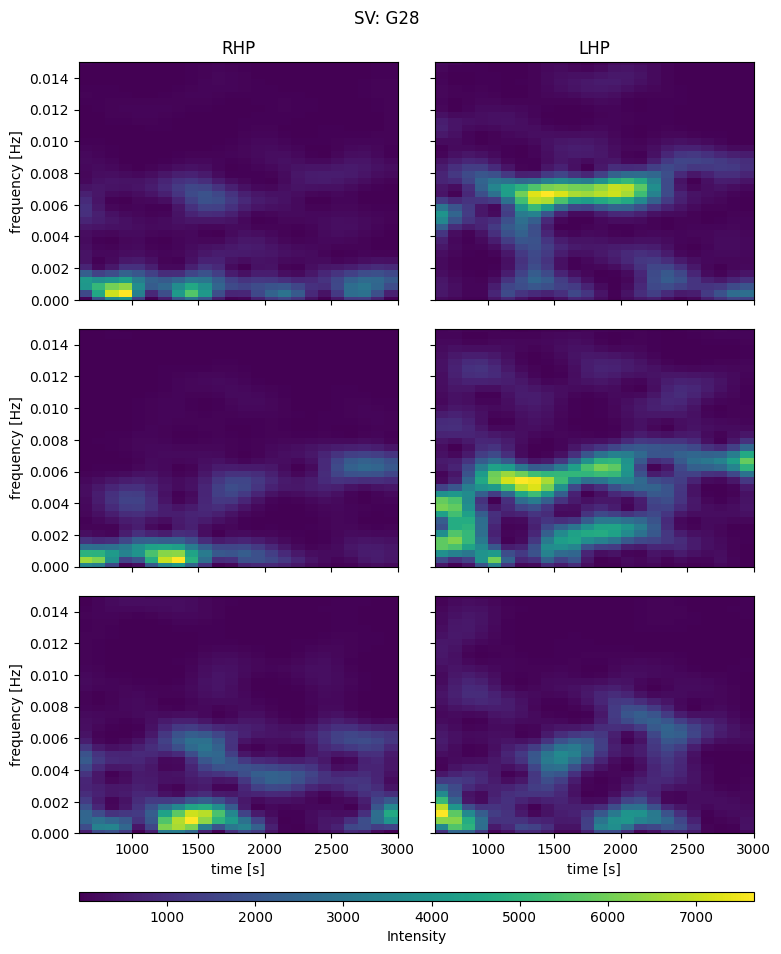

In [50]:
## Spectrogram block for LHP and RHP signals

PLOT_SCALED_DATA = False

PERFORM_MOVING_AVERAGE = False

PERFORM_WHOLE_AMPLITUDE_NORMALIZATION = False
PERFORM_HALF_AMPLITUDE_NORMALIZATION = False
PERFORM_GENERAL_AMPLITUDE_NORMALIZATION = False

WINDOW_SIZE = 14

if not WINDOW_SIZE % 2 == 0:
    WINDOW_SIZE += 1

for sv in sv_list:
    if sv not in interesting_svs:
        continue

    cn0_L1_main = obs_main.sel(sv=sv)[CN0_L1_selector].values
    cn0_L2_main = obs_main.sel(sv=sv)[CN0_L2_selector].values
    cn0_L5_main = obs_main.sel(sv=sv)[CN0_L5_selector].values

    cn0_L1_aux = obs_aux.sel(sv=sv)[CN0_L1_selector].values
    cn0_L2_aux = obs_aux.sel(sv=sv)[CN0_L2_selector].values
    cn0_L5_aux = obs_aux.sel(sv=sv)[CN0_L5_selector].values

    if np.sum(np.isnan(cn0_L1_aux)) > 0:
        cn0_L1_aux = interpolate_nans(cn0_L1_aux)

    if np.sum(np.isnan(cn0_L2_aux)) > 0:
        cn0_L2_aux = interpolate_nans(cn0_L2_aux)

    if np.sum(np.isnan(cn0_L5_aux)) > 0:
        cn0_L5_aux = interpolate_nans(cn0_L5_aux)

    if PERFORM_GENERAL_AMPLITUDE_NORMALIZATION:
        cn0_L1_main_norm = normalize_amplitude_timeseries(cn0_L1_main)
        cn0_L2_main_norm = normalize_amplitude_timeseries(cn0_L2_main)
        cn0_L5_main_norm = normalize_amplitude_timeseries(cn0_L5_main)
        cn0_L1_aux_norm = normalize_amplitude_timeseries(cn0_L1_aux)
        cn0_L2_aux_norm = normalize_amplitude_timeseries(cn0_L2_aux)
        cn0_L5_aux_norm = normalize_amplitude_timeseries(cn0_L5_aux)
    elif PERFORM_HALF_AMPLITUDE_NORMALIZATION:
        cn0_L1_main_norm = normalize_amplitude_timeseries_half(cn0_L1_main)
        cn0_L2_main_norm = normalize_amplitude_timeseries_half(cn0_L2_main)
        cn0_L5_main_norm = normalize_amplitude_timeseries_half(cn0_L5_main)
        cn0_L1_aux_norm = normalize_amplitude_timeseries_half(cn0_L1_aux)
        cn0_L2_aux_norm = normalize_amplitude_timeseries_half(cn0_L2_aux)
        cn0_L5_aux_norm = normalize_amplitude_timeseries_half(cn0_L5_aux)
    elif PERFORM_WHOLE_AMPLITUDE_NORMALIZATION:
        cn0_L1_main_norm = normalize_amplitude_timeseries_whole(cn0_L1_main)
        cn0_L2_main_norm = normalize_amplitude_timeseries_whole(cn0_L2_main)
        cn0_L5_main_norm = normalize_amplitude_timeseries_whole(cn0_L5_main)
        cn0_L1_aux_norm = normalize_amplitude_timeseries_whole(cn0_L1_aux)
        cn0_L2_aux_norm = normalize_amplitude_timeseries_whole(cn0_L2_aux)
        cn0_L5_aux_norm = normalize_amplitude_timeseries_whole(cn0_L5_aux)
    else:
        cn0_L1_main_norm = cn0_L1_main
        cn0_L2_main_norm = cn0_L2_main
        cn0_L5_main_norm = cn0_L5_main
        cn0_L1_aux_norm = cn0_L1_aux
        cn0_L2_aux_norm = cn0_L2_aux
        cn0_L5_aux_norm = cn0_L5_aux

    if PERFORM_MOVING_AVERAGE:
        cn0_L1_main_norm = moving_average(cn0_L1_main_norm,window_size=WINDOW_SIZE)
        cn0_L2_main_norm = moving_average(cn0_L2_main_norm,window_size=WINDOW_SIZE)
        cn0_L5_main_norm = moving_average(cn0_L5_main_norm,window_size=WINDOW_SIZE)
        cn0_L1_aux_norm = moving_average(cn0_L1_aux_norm,window_size=WINDOW_SIZE)
        cn0_L2_aux_norm = moving_average(cn0_L2_aux_norm,window_size=WINDOW_SIZE)
        cn0_L5_aux_norm = moving_average(cn0_L5_aux_norm,window_size=WINDOW_SIZE)


    window = 'blackmanharris'
    nperseg = 1300
    nfft = 2400
    noverlap = 1200
    
    signal_labels = ['RHP', 'LHP']
    cmap = 'viridis'

    f_L1_main, t_L1_main, Sxx_L1_main = scipy.signal.spectrogram(cn0_L1_main_norm, fs = 1, 
                                                                    window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap)
    f_L1_aux, t_L1_aux, Sxx_L1_aux = scipy.signal.spectrogram(cn0_L1_aux_norm, fs = 1, 
                                                                    window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap)

    f_L2_main, t_L2_main, Sxx_L2_main = scipy.signal.spectrogram(cn0_L2_main_norm, fs = 1, 
                                                                    window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap)
    f_L2_aux, t_L2_aux, Sxx_L2_aux = scipy.signal.spectrogram(cn0_L2_aux_norm, fs = 1, 
                                                                    window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap)

    f_L5_main, t_L5_main, Sxx_L5_main = scipy.signal.spectrogram(cn0_L5_main_norm, fs = 1, 
                                                                    window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap)
    f_L5_aux, t_L5_aux, Sxx_L5_aux = scipy.signal.spectrogram(cn0_L5_aux_norm, fs = 1, 
                                                                    window = window, nfft = nfft, nperseg = nperseg, noverlap = noverlap)

    fig, ax = plt.subplots(3,2,sharex=True,sharey=True,figsize=(8,9))
    plt.suptitle(f'SV: {sv}')
    im0 = ax[0,0].pcolormesh(t_L1_main, f_L1_main, Sxx_L1_main, shading='nearest',cmap=cmap)
    im1 = ax[0,1].pcolormesh(t_L1_aux, f_L1_aux, Sxx_L1_aux, shading='nearest',cmap=cmap)

    im2 = ax[1,0].pcolormesh(t_L2_main, f_L2_main, Sxx_L2_main, shading='nearest',cmap=cmap)
    im3 = ax[1,1].pcolormesh(t_L2_aux, f_L2_aux, Sxx_L2_aux, shading='nearest',cmap=cmap)

    im4 = ax[2,0].pcolormesh(t_L5_main, f_L5_main, Sxx_L5_main, shading='nearest',cmap=cmap)
    im5 = ax[2,1].pcolormesh(t_L5_aux, f_L5_aux, Sxx_L5_aux, shading='nearest',cmap=cmap)

    for i in range(0,2):
        ax[2,i].set_xlabel('time [s]')
        ax[0,i].set_title(f'{signal_labels[i]}')
    for i in range(0,3):
        ax[i,0].set_ylabel('frequency [Hz]')

    ax[2,1].set_ylim([0,0.015])

    cbar_ax = fig.add_axes([0.116, -0.01, 0.844, 0.01])  # [left, bottom, width, height]
    cbar = fig.colorbar(im1, cax=cbar_ax, orientation='horizontal')
    cbar.set_label('Intensity')

    plt.tight_layout()
    plt.show()


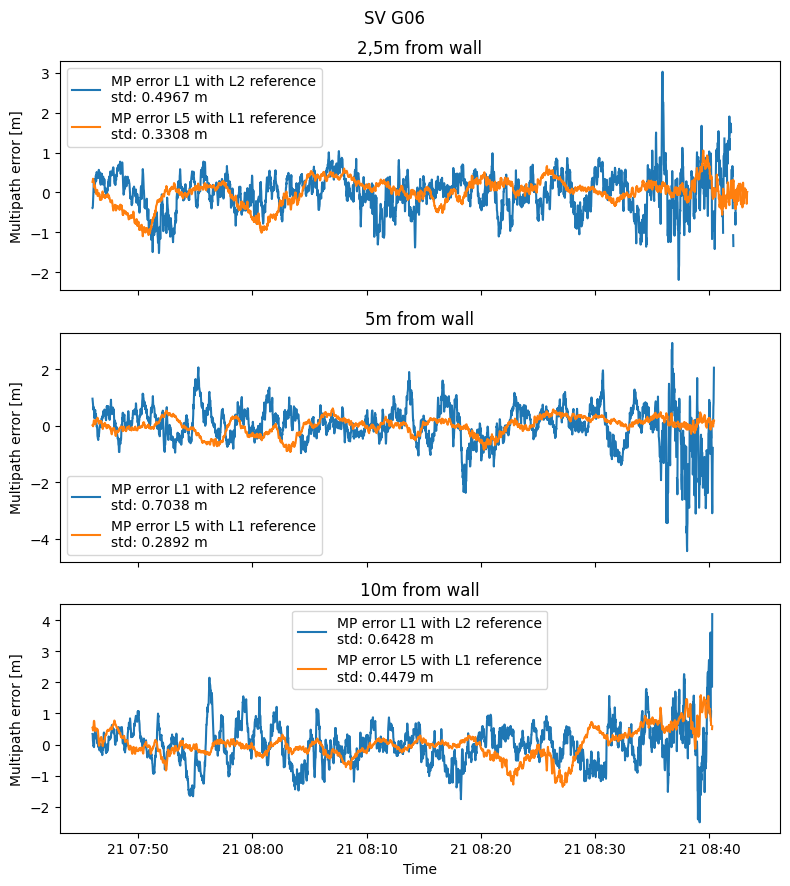

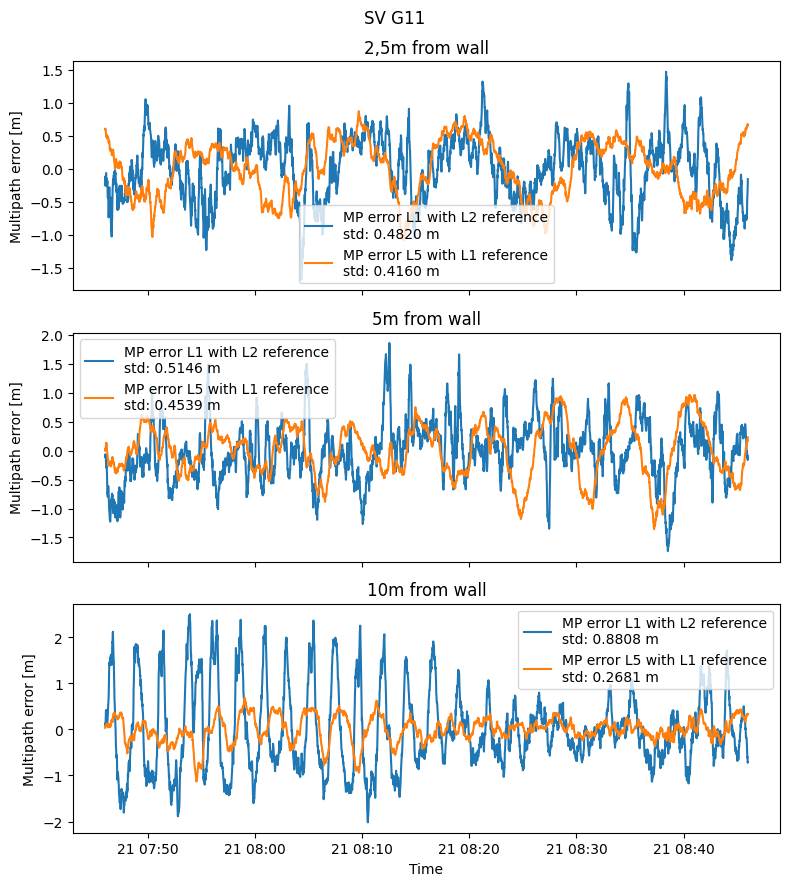

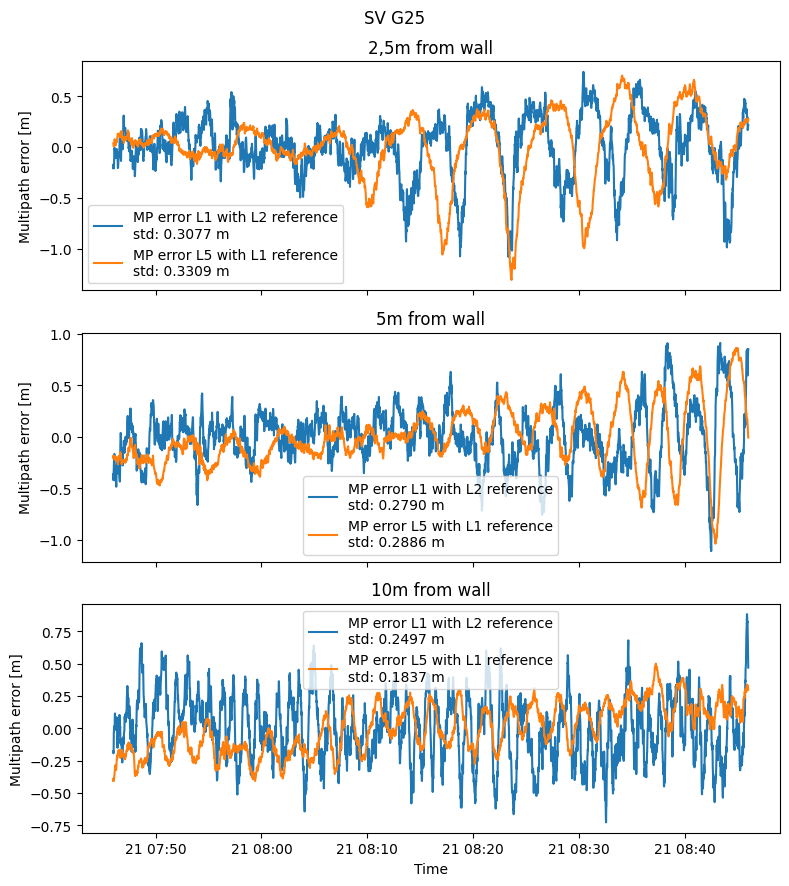

In [ ]:
## MP error block

if wall_type == 'brick':
    save_fig = ['G25', 'G11']

for sv in sv_list:

    if not np.sum(np.isnan(obs_short.sel(sv=sv)[CN0_L5_selector].values)) == len(obs_short.sel(sv=sv)[CN0_L5_selector].values):
        pseudorange_L1 = obs_short.sel(sv=sv)[pseudorange_L1_selector]
        pseudorange_L2 = obs_short.sel(sv=sv)[pseudorange_L2_selector]
        pseudorange_L5 = obs_short.sel(sv=sv)[pseudorange_L5_selector]

        carrier_phase_L1 = obs_short.sel(sv=sv)[carrier_phase_L1_selector]
        carrier_phase_L2 = obs_short.sel(sv=sv)[carrier_phase_L2_selector]
        carrier_phase_L5 = obs_short.sel(sv=sv)[carrier_phase_L5_selector]

        mp_L1L2_short = calculate_multipath_error(pseudorange_L1, freq_L1, carrier_phase_L1, freq_L2, carrier_phase_L2)
        mp_L5L1_short = calculate_multipath_error(pseudorange_L5, freq_L5, carrier_phase_L5, freq_L1, carrier_phase_L1)

        pseudorange_L1 = obs_medium.sel(sv=sv)[pseudorange_L1_selector]
        pseudorange_L2 = obs_medium.sel(sv=sv)[pseudorange_L2_selector]
        pseudorange_L5 = obs_medium.sel(sv=sv)[pseudorange_L5_selector]

        carrier_phase_L1 = obs_medium.sel(sv=sv)[carrier_phase_L1_selector]
        carrier_phase_L2 = obs_medium.sel(sv=sv)[carrier_phase_L2_selector]
        carrier_phase_L5 = obs_medium.sel(sv=sv)[carrier_phase_L5_selector]

        mp_L1L2_medium = calculate_multipath_error(pseudorange_L1, freq_L1, carrier_phase_L1, freq_L2, carrier_phase_L2)
        mp_L5L1_medium = calculate_multipath_error(pseudorange_L5, freq_L5, carrier_phase_L5, freq_L1, carrier_phase_L1)

        pseudorange_L1 = obs_long.sel(sv=sv)[pseudorange_L1_selector]
        pseudorange_L2 = obs_long.sel(sv=sv)[pseudorange_L2_selector]
        pseudorange_L5 = obs_long.sel(sv=sv)[pseudorange_L5_selector]

        carrier_phase_L1 = obs_long.sel(sv=sv)[carrier_phase_L1_selector]
        carrier_phase_L2 = obs_long.sel(sv=sv)[carrier_phase_L2_selector]
        carrier_phase_L5 = obs_long.sel(sv=sv)[carrier_phase_L5_selector]

        mp_L1L2_long = calculate_multipath_error(pseudorange_L1, freq_L1, carrier_phase_L1, freq_L2, carrier_phase_L2)
        mp_L5L1_long = calculate_multipath_error(pseudorange_L5, freq_L5, carrier_phase_L5, freq_L1, carrier_phase_L1)

        fig,ax = plt.subplots(3,1,figsize=(8,9), sharex=True)
        fig.suptitle(f'SV {sv}')
        ax[0].plot(obs_short[pseudorange_L1_selector].sel(sv=sv).time.values,mp_L1L2_short,label=f'MP error L1 with L2 reference\nstd: {np.nanstd(mp_L1L2_short):.4f} m')
        ax[0].plot(obs_short[pseudorange_L1_selector].sel(sv=sv).time.values,mp_L5L1_short,label=f'MP error L5 with L1 reference\nstd: {np.nanstd(mp_L5L1_short):.4f} m')
        ax[0].set_ylabel('Multipath error [m]')
        ax[0].set_title('2,5m from wall')
        ax[0].legend()

        ax[1].plot(obs_medium[pseudorange_L1_selector].sel(sv=sv).time.values,mp_L1L2_medium,label=f'MP error L1 with L2 reference\nstd: {np.nanstd(mp_L1L2_medium):.4f} m')
        ax[1].plot(obs_medium[pseudorange_L1_selector].sel(sv=sv).time.values,mp_L5L1_medium,label=f'MP error L5 with L1 reference\nstd: {np.nanstd(mp_L5L1_medium):.4f} m')
        ax[1].set_ylabel('Multipath error [m]')
        ax[1].set_title('5m from wall')
        ax[1].legend()

        ax[2].plot(obs_long[pseudorange_L1_selector].sel(sv=sv).time.values,mp_L1L2_long,label=f'MP error L1 with L2 reference\nstd: {np.nanstd(mp_L1L2_long):.4f} m')
        ax[2].plot(obs_long[pseudorange_L1_selector].sel(sv=sv).time.values,mp_L5L1_long,label=f'MP error L5 with L1 reference\nstd: {np.nanstd(mp_L5L1_long):.4f} m')
        ax[2].set_ylabel('Multipath error [m]')
        ax[2].set_title('10m from wall')
        ax[2].set_xlabel('Time')
        ax[2].legend()

        plt.tight_layout()

        plt.tight_layout()
        plt.savefig(f'..{os.sep}figs{os.sep}distance_correlation{os.sep}mp_errors{os.sep}mp_errors_distance_correlation_{sv}_{wall_type}_{date}.png')
        plt.savefig(f'..{os.sep}figs{os.sep}distance_correlation{os.sep}mp_errors{os.sep}mp_errors_distance_correlation_{sv}_{wall_type}_{date}.pdf')

        plt.show()